# Assignment2 - Supervised Learning flow

# Part 1(a) Student details:
* Please write the First-Name, First letter of Last-Name and last 4 digits of the i.d. for each student. 

In [1]:
# stundent details:
# Michael O J 5140
# Agam M 6895
# Ofek L 8567

## Part 1(b) - Chat-GPT/other AI-agent/other assistance used:
* If you changed the prompt until you got a satisfying answer, please add all versions
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add information:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>   
AI agent name: Coplilot
Goal: Help us write proper code, prevent errors and to understand the pipeline better.
Propmpt1:
    "Fix the highlighted code"
Propmpt2:
    "Why do i get this error?"
Propmpt3:
    "Explain hyperparameters and their importance in ML"


AI agent name 2:
Goal:
Propmpt1:

Propmpt2:

Propmpt3:


Other assistanse:    
</pre>

## Part 1(c) - Learning Problem and dataset explaination.
* Please explain in one paragraph
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add explaining text:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>
The learning problem involves predicting the median house value (`MedHouseVal`) based on various features such as the average number of rooms (`AveRooms`), population size (`Population`), and other housing-related attributes. The dataset used for this task is a housing dataset split into training (`housing_train.csv`) and test (`housing_test.csv`) sets. The training set is used to build and optimize machine learning models, while the test set is used to evaluate the model's performance. The goal is to identify the best combination of feature engineering techniques and algorithms to achieve accurate predictions of house prices.
</pre>

## Part 2 - Initial Preparations 
You could add as many code cells as needed

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

In [10]:
df_train = pd.read_csv("housing_train.csv")
df_test = pd.read_csv("housing_test.csv")

In [11]:
df_train.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,4.0179,46.0,4.158690,1.032746,512.0,1.289673,34.07,-118.35,3.500
1,2.7002,6.0,4.149245,1.179989,4092.0,2.287311,34.05,-117.31,0.883
2,1.2762,17.0,3.432331,1.022556,1325.0,2.490602,34.42,-119.69,2.536
3,4.9342,23.0,5.735798,1.053201,4580.0,4.129847,34.04,-117.93,1.810
4,2.2755,21.0,4.064607,0.962079,2109.0,2.962079,32.58,-117.11,1.250


In [5]:
df_test.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,4.0179,46.0,4.158690,1.032746,512.0,1.289673,34.07,-118.35,3.500
1,2.7002,6.0,4.149245,1.179989,4092.0,2.287311,34.05,-117.31,0.883
2,1.2762,17.0,3.432331,1.022556,1325.0,2.490602,34.42,-119.69,2.536
3,4.9342,23.0,5.735798,1.053201,4580.0,4.129847,34.04,-117.93,1.810
4,2.2755,21.0,4.064607,0.962079,2109.0,2.962079,32.58,-117.11,1.250


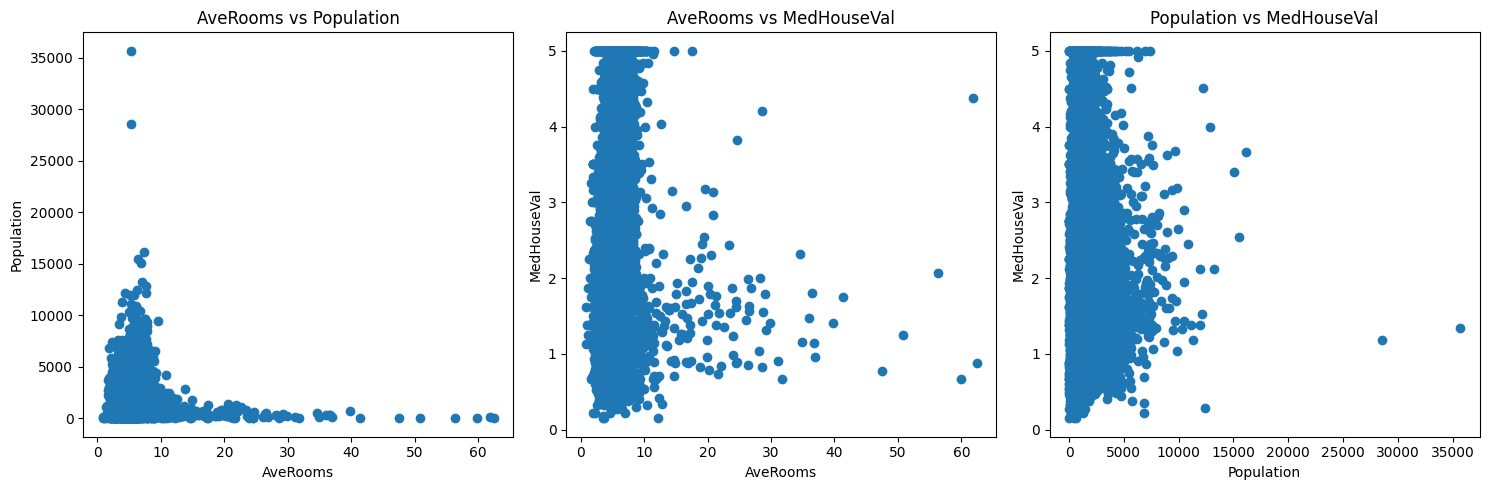

In [12]:
figure, axes = plt.subplots(1, 3, figsize=(15, 5))

col1, col2, col3 = "AveRooms", "Population", "MedHouseVal"

axes[0].scatter(df_train[col1], df_train[col2])
axes[0].set_xlabel(col1)
axes[0].set_ylabel(col2)
axes[0].set_title(f'{col1} vs {col2}')

axes[1].scatter(df_train[col1], df_train[col3])
axes[1].set_xlabel(col1)
axes[1].set_ylabel(col3)
axes[1].set_title(f'{col1} vs {col3}')

axes[2].scatter(df_train[col2], df_train[col3])
axes[2].set_xlabel(col2)
axes[2].set_ylabel(col3)
axes[2].set_title(f'{col2} vs {col3}')

plt.tight_layout()
plt.show()

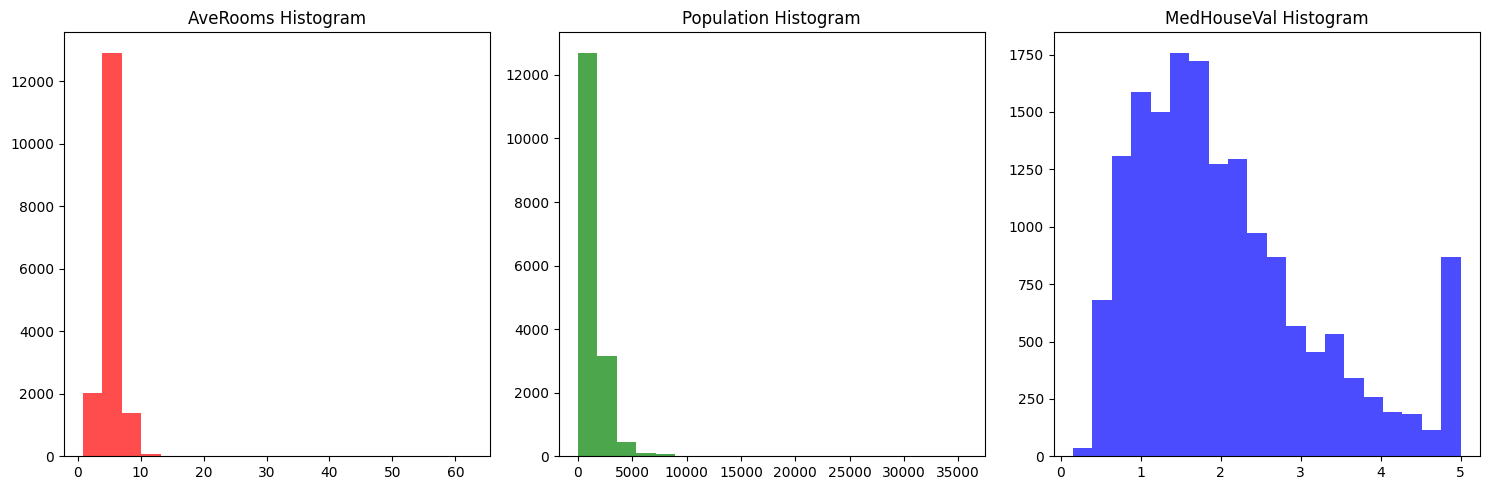

In [13]:
figure , axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(df_train[col1], bins=20, color='red', alpha=0.7)
axes[0].set_title(f'{col1} Histogram')
# מטרה לראות את הקשר בין כמות אוכלסיה לכמות ממוצעות של חדרים לבדוק אם יש קשר בין השניים
# ככל שהאוכלסיה גדלה כך ממוצע החדרים ירד

axes[1].hist(df_train[col2], bins=20, color='green', alpha=0.7)
axes[1].set_title(f'{col2} Histogram')
# להראות את הקשר בין כמות החדרים לבין מחירי הבתים
# לא קיים קשר בין כמות חדרים לבין מחיר הדירה

axes[2].hist(df_train[col3], bins=20, color='blue', alpha=0.7)
axes[2].set_title(f'{col3} Histogram')
# להראות את השר בין כמות אוכלוסייה לבין מחירי הבתים
# קיים קשר חלש  בין כמות אוכלוסיה לבין מחיר הדיור

plt.tight_layout()
plt.show()

In [28]:
corr = df_train.corr(method = 'pearson')
corr

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
MedInc,1.000000,-0.117388,0.384752,-0.075673,0.001775,0.021997,-0.086246,-0.009476,0.686058
HouseAge,-0.117388,1.000000,-0.179281,-0.098112,-0.297913,0.015067,0.011265,-0.107945,0.108339
AveRooms,0.384752,-0.179281,1.000000,0.790688,-0.077764,-0.005240,0.108839,-0.025819,0.168320
AveBedrms,-0.075673,-0.098112,0.790688,1.000000,-0.070910,-0.006776,0.070486,0.021934,-0.065581
Population,0.001775,-0.297913,-0.077764,-0.070910,1.000000,0.071879,-0.104153,0.094613,-0.025100
AveOccup,0.021997,0.015067,-0.005240,-0.006776,0.071879,1.000000,0.006104,-0.000632,-0.022339
Latitude,-0.086246,0.011265,0.108839,0.070486,-0.104153,0.006104,1.000000,-0.925316,-0.148847
Longitude,-0.009476,-0.107945,-0.025819,0.021934,0.094613,-0.000632,-0.925316,1.000000,-0.041367
MedHouseVal,0.686058,0.108339,0.168320,-0.065581,-0.025100,-0.022339,-0.148847,-0.041367,1.000000


The purpose of the visualizations is to explore the relationships and distributions of key features in the dataset. Scatter plots are used to examine potential correlations between variables (such as average rooms, population, and median house value), while histograms provide insights into the distribution of each feature, helping to identify patterns, outliers, or skewness in the data.

## Part 3 - Experiments
You could add as many code cells as needed

In [15]:
# Feature engineering options
feature_options = [
    [],  # No transformation
    ['scale'],  # Standard scaling
    ['poly2'],  # Polynomial degree 2
    ['scale', 'poly2'],  # Scaling + polynomial
    ['selectk']  # Feature selection
]

# Models and their hyperparameters
models = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Ridge': {
        'model': Ridge(),
        'params': {'model__alpha': [0.1, 1, 10]}
    },
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {'model__n_estimators': [50, 100], 'model__max_depth': [3, 5, None]}
    }
}

results = []

X = df_train.drop('MedHouseVal', axis=1)
y = df_train['MedHouseVal']

In [16]:
for feats in feature_options:
    steps = []
    feats_name = []
    if 'scale' in feats:
        steps.append(('scaler', StandardScaler()))
        feats_name.append('scale')
    if 'poly2' in feats:
        steps.append(('poly', PolynomialFeatures(degree=2, include_bias=False)))
        feats_name.append('poly2')
    if 'selectk' in feats:
        steps.append(('selectk', SelectKBest(score_func=f_regression, k=2)))
        feats_name.append('selectk')
    for model_name, model_dict in models.items():
        pipe_steps = steps + [('model', model_dict['model'])]
        pipe = Pipeline(pipe_steps)
        param_grid = model_dict['params']
        # GridSearchCV with 5-fold cross-validation
        grid = GridSearchCV(pipe, param_grid, cv=5, scoring=make_scorer(mean_squared_error, greater_is_better=False), n_jobs=-1)
        grid.fit(X, y)
        results.append({
            'Feature Engineering': '+'.join(feats_name) if feats_name else 'none',
            'Model': model_name,
            'Best Params': grid.best_params_,
            'CV Mean MSE': -grid.best_score_,
            'R² Score':  grid.best_estimator_.score(X, y)
        })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('CV Mean MSE')
isplay(results_df)

C:\Users\agamm\PycharmProjects\Global venv\.venv\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.53955e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


,Feature Engineering,Model,Best Params,CV Mean MSE,R² Score
5,scale,RandomForest,"{'model__max_depth': None, 'model__n_estimator...",0.268901,0.972836
2,none,RandomForest,"{'model__max_depth': None, 'model__n_estimator...",0.268924,0.972834
11,scale+poly2,RandomForest,"{'model__max_depth': None, 'model__n_estimator...",0.276006,0.972495
8,poly2,RandomForest,"{'model__max_depth': None, 'model__n_estimator...",0.279011,0.971955
1,none,Ridge,{'model__alpha': 10},0.523862,0.606179
4,scale,Ridge,{'model__alpha': 10},0.523925,0.606179
3,scale,LinearRegression,{},0.523930,0.606186
0,none,LinearRegression,{},0.523930,0.606186
10,scale+poly2,Ridge,{'model__alpha': 10},0.644696,0.679523
7,poly2,Ridge,{'model__alpha': 1},0.702734,0.676319


Feature Importance:


,Feature,Importance
0,MedInc,0.515865
5,AveOccup,0.141285
6,Latitude,0.091422
7,Longitude,0.089682
1,HouseAge,0.053643
2,AveRooms,0.045679
4,Population,0.032502
3,AveBedrms,0.029922


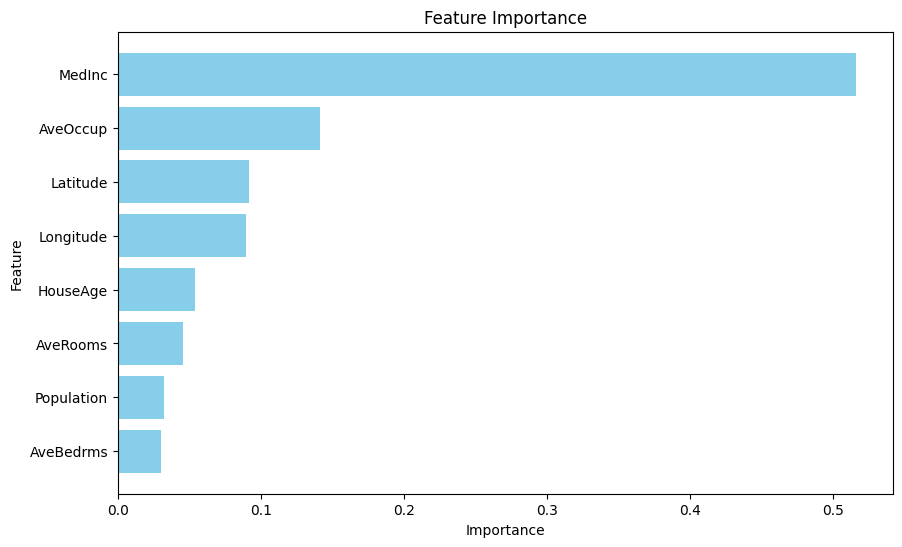

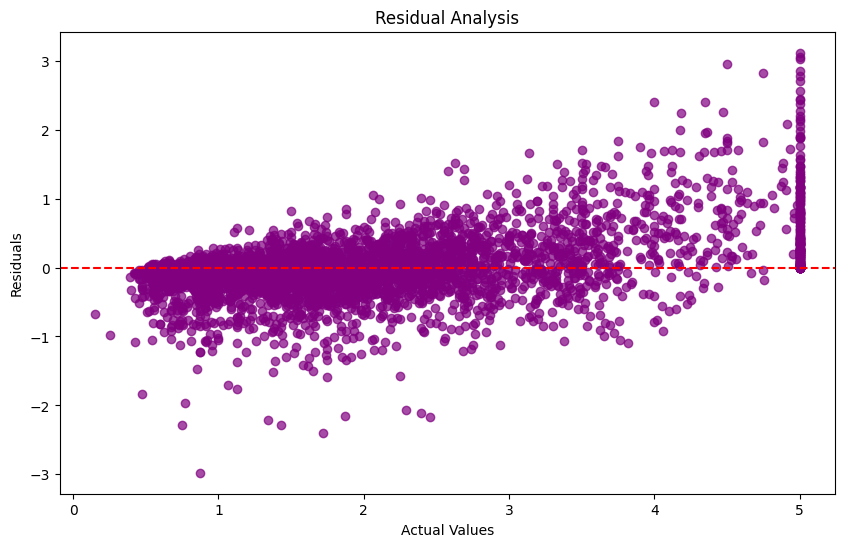

In [40]:
# If the best model is a tree-based model (e.g., RandomForest), show feature importance
if hasattr(best_model, 'feature_importances_'):
    feature_importance = best_model.feature_importances_
    feature_names = X.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print("Feature Importance:")
    display(importance_df)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()
    plt.show()

# Residual Analysis
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.7, color='purple')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

## Part 4 - Training 
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 3)

In [35]:
best_result = results_df.iloc[0]
best_features = best_result['Feature Engineering'].split('+') if best_result['Feature Engineering'] != 'none' else []
best_model_name = best_result['Model']
best_params = {k: v for k, v in best_result['Best Params'].items() if k != 'model__model'}

steps = []
if 'scale' in best_features:
    steps.append(('scaler', StandardScaler()))
if 'poly2' in best_features:
    steps.append(('poly', PolynomialFeatures(degree=2, include_bias=False)))
if 'selectk' in best_features:
    steps.append(('selectk', SelectKBest(score_func=f_regression, k=2)))

best_model = models[best_model_name]['model']
steps.append(('model', best_model))

pipeline = Pipeline(steps)

pipeline.set_params(**best_params)

pipeline.fit(X, y)

0.9728357478990877

## Part 5 - Apply on test and show model performance estimation

In [37]:
X_test = df_test.drop('MedHouseVal', axis=1)
y_test = df_test['MedHouseVal']

y_pred = pipeline.predict(X_test)

cv_scores = cross_val_score(pipeline, X_test, y_test, cv=5, scoring=make_scorer(mean_squared_error, greater_is_better=False))
mean_cv_mse = -cv_scores.mean()
score = pipeline.score(X_test, y_test)

print(f"Cross-Validation Mean MSE on Test Set: {mean_cv_mse}")
print(f"R² Score on Test Set: {score}")

5 Predictions on Test Set:
[3.3150102 2.40763   2.61322   1.14609   1.26805  ]
Cross-Validation Mean MSE on Test Set: 0.3136960055216222
R² Score on Test Set: 0.8234524563906225
